In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [2]:
# Read Data

training_data_df = pd.read_csv('./prepped_data/training_data_ver_2.csv')
print(training_data_df.shape)
training_data_df.head()

(4348077, 294)


,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,(한강)오염행위 제한지역,(한강)폐기물매립시설 설치제한지역,가로구역별 최고높이 제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가·착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택 공급촉진지구,공공청사,공동구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,과밀억제권역,광로1류(폭 70M 이상),광로2류(폭 50M~70M),광로3류(폭 40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도:54-236m),대공방어협조구역(위탁고도:77-257m),대로1류(폭 35M~40M),대로2류(폭 30M~35M),대로3류(폭 25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획 입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향 검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상수원보호구역,생산녹지지역,소공원,소로1류(폭 10M~12M),소로2류(폭 8M~10M),소로3류(폭 8M 미만),소하천,소하천구역,수도공급시설,수평표면구역,시·도 생태·경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종 구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공:5km),제한보호구역(후방지역:500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭 20M~25M),중로2류(폭 15M~20M),중로3류(폭 12M~15M),중심대광장,중심상업지역,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역(민통선이남:300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,하수도,하수종말처리시설,하천,하천구역,학교,학교이적지,현상변경허가 대상구역,홍수관리구역,x_norm,y_norm,year_linear,month_sine,month_cosine
0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.666667,-0.866025,-0.500000
1,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.916667,-0.500000,0.866025
2,1,77.75,35000,0,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [3]:
basedir = './feature_maps/'
col_map_df = pd.read_csv(basedir + 'col_map.csv')
floor_map_df = pd.read_csv(basedir + 'floor_map.csv')
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [4]:
col_map = {}
for i in range(col_map_df.shape[0]):
    col_map[col_map_df['col_name'][i]] = '{}'.format(col_map_df['col_map'][i])
col_map

{'trade_type': '0',
 '전용면적(㎡)': '1',
 '금액(만원)': '2',
 '월세(만원)': '3',
 '가격/면적': '4',
 '층': '5',
 '건물나이': '6',
 'target_log_transformed': '7',
 'target/area_log_transformed': '8',
 '특수지구분명': '9',
 '공시지가': '10',
 '표준지여부': '11',
 '지목코드': '12',
 '토지면적': '13',
 '용도지역코드1': '14',
 '용도지역코드2': '15',
 '지형높이코드': '16',
 '지형형상코드': '17',
 '도로접면코드': '18',
 '(한강)오염행위 제한지역': '19',
 '(한강)폐기물매립시설 설치제한지역': '20',
 '가로구역별 최고높이 제한지역': '21',
 '가스공급설비': '22',
 '가축사육제한구역': '23',
 '개발제한구역': '24',
 '개발진흥지구': '25',
 '개발행위허가제한지역': '26',
 '건축선': '27',
 '건축용도지역기타': '28',
 '건축용도지역미분류': '29',
 '건축허가·착공제한지역': '30',
 '경관광장': '31',
 '경관녹지': '32',
 '경관지구': '33',
 '경관지구기타': '34',
 '고도지구': '35',
 '고등학교': '36',
 '고속철도': '37',
 '공공공지': '38',
 '공공도서관': '39',
 '공공문화체육시설미분류': '40',
 '공공시설구역': '41',
 '공공주택지구': '42',
 '공공지원민간임대주택 공급촉진지구': '43',
 '공공청사': '44',
 '공동구': '45',
 '공원': '46',
 '공원마을지구(공원집단시설지구)': '47',
 '공원자연보존지구': '48',
 '공원자연환경지구': '49',
 '공익용산지': '50',
 '공익임지': '51',
 '공장설립승인지역': '52',
 '공장설립제한지역': '53',
 '공항소음피해예상지역': 

In [5]:
cat_cols = [cat_cols_df['cat_cols'][i] for i in range(cat_cols_df.shape[0])]
cat_cols.remove('층')
cat_cols.remove('건물나이')
cat_cols[:5]

['trade_type', '특수지구분명', '표준지여부', '지목코드', '용도지역코드1']

In [6]:
cat_cols_mapped = [col_map[v] for v in cat_cols]
print(len(cat_cols_mapped))
cat_cols_mapped[:5]

279


['0', '9', '11', '12', '14']

In [7]:
training_data_df.columns = [v for v in col_map.values()]

In [8]:
training_data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293
0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.666667,-0.866025,-0.500000
1,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.916667,-0.500000,0.866025
2,1,77.75,35000,0,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.000000,0.000000,1.000000
3,1,77.75,32000,0,411.575563,9,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.166667,0.866025,0.500000
4,1,77.75,37000,0,475.884244,1,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

In [9]:
trade_type_map_df = pd.read_csv(basedir + 'trade_type_map.csv')
trade_type_map_df.head()

,아파트_매매,아파트_전세,아파트_월세,다세대연립_매매,다세대연립_전세,다세대연립_월세,오피스텔_매매,오피스텔_전세,오피스텔_월세
0,0,1,2,3,4,5,6,7,8


In [10]:
trade_type_map = trade_type_map_df.to_dict(orient='records')[0]
trade_type_map

{'아파트_매매': 0,
 '아파트_전세': 1,
 '아파트_월세': 2,
 '다세대연립_매매': 3,
 '다세대연립_전세': 4,
 '다세대연립_월세': 5,
 '오피스텔_매매': 6,
 '오피스텔_전세': 7,
 '오피스텔_월세': 8}

In [11]:
training_data_df.shape

(4348077, 294)

In [12]:
no_monthly_pay_df = training_data_df[(training_data_df['0']!=2)&(training_data_df['0']!=5)&(training_data_df['0']!=8)].reset_index(drop=True)
print(no_monthly_pay_df.shape)
no_monthly_pay_df.head()

(3551733, 294)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293
0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.666667,-0.866025,-0.500000
1,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.916667,-0.500000,0.866025
2,1,77.75,35000,0,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.000000,0.000000,1.000000
3,1,77.75,32000,0,411.575563,9,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.166667,0.866025,0.500000
4,1,77.75,37000,0,475.884244,1,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

In [13]:
no_monthly_pay_df['0'].value_counts()

0    1083300
1    1066580
3     614107
4     515136
6     163652
7     108958
Name: 0, dtype: int64

In [14]:
no_monthly_pay_df = no_monthly_pay_df.drop(columns=['3'])

In [15]:
no_monthly_pay_df['x_coor_2nd'] = no_monthly_pay_df['289']**2/2
no_monthly_pay_df['y_coor_2nd'] = no_monthly_pay_df['290']**2/2
no_monthly_pay_df['x_coor_3rd'] = no_monthly_pay_df['289']**3/math.factorial(3)
no_monthly_pay_df['y_coor_3rd'] = no_monthly_pay_df['290']**3/math.factorial(3)
no_monthly_pay_df['x_coor_4th'] = no_monthly_pay_df['289']**4/math.factorial(4)
no_monthly_pay_df['y_coor_4th'] = no_monthly_pay_df['290']**4/math.factorial(4)
no_monthly_pay_df['x_coor_5th'] = no_monthly_pay_df['289']**5/math.factorial(5)
no_monthly_pay_df['y_coor_5th'] = no_monthly_pay_df['290']**5/math.factorial(5)
no_monthly_pay_df['x*y'] = no_monthly_pay_df['289']*no_monthly_pay_df['290']
no_monthly_pay_df['x_coor_sin'] = no_monthly_pay_df['289'].apply(np.sin)
no_monthly_pay_df['y_coor_sin'] = no_monthly_pay_df['290'].apply(np.sin)
no_monthly_pay_df['x_coor_cos'] = no_monthly_pay_df['289'].apply(np.cos)
no_monthly_pay_df['y_coor_cos'] = no_monthly_pay_df['290'].apply(np.cos)

In [16]:
print(no_monthly_pay_df.shape)
no_monthly_pay_df.head()

(3551733, 306)


,0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,x_coor_2nd,y_coor_2nd,x_coor_3rd,y_coor_3rd,x_coor_4th,y_coor_4th,x_coor_5th,y_coor_5th,x*y,x_coor_sin,y_coor_sin,x_coor_cos,y_coor_cos
0,0,77.75,57000,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.666667,-0.866025,-0.500000,251.453792,13.382793,1879.667478,23.078835,10538.168264,29.849858,47264.951544,30.885928,116.019896,-0.420914,-0.895538,-0.907101,0.444985
1,0,77.75,57000,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.916667,-0.500000,0.866025,251.453792,13.382793,1879.667478,23.078835,10538.168264,29.849858,47264.951544,30.885928,116.019896,-0.420914,-0.895538,-0.907101,0.444985
2,1,77.75,35000,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.000000,0.000000,1.000000,251.453792,13.382793,1879.667478,23.078835,10538.168264,29.849858,47264.951544,30.885928,116.019896,-0.420914,-0.895538,-0.907101,0.444985
3,1,77.75,32000,411.575563,9,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

In [17]:
test_data = no_monthly_pay_df.sample(frac=0.2)
train_data = no_monthly_pay_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

(710347, 306)
(568277, 306)
(2273109, 306)


In [18]:
target_cols = ['금액(만원)', '가격/면적', 'target_log_transformed', 'target/area_log_transformed']
target_cols_mapped = [col_map[col] for col in target_cols]
target_cols_mapped

['2', '4', '7', '8']

In [19]:
x_test = test_data.drop(columns=target_cols_mapped)
y_test = test_data['2']
print(x_test.shape)
print(y_test.shape)

(710347, 302)
(710347,)


In [20]:
x_valid = valid_data.drop(columns=target_cols_mapped)
y_valid = valid_data['2']
print(x_valid.shape)
print(y_valid.shape)

(568277, 302)
(568277,)


In [21]:
x_train = train_data.drop(columns=target_cols_mapped)
y_train = train_data['2']
print(x_train.shape)
print(y_train.shape)

(2273109, 302)
(2273109,)


<AxesSubplot:>

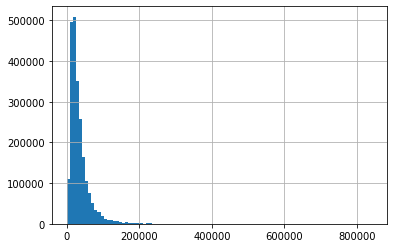

In [22]:
y_train.hist(bins=100)

# Training

In [23]:
from sklearn.metrics import r2_score

# ML Models

# Light GBM

In [24]:
import lightgbm as lgb

In [25]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'seed': 42,
    'max_depth': -1,
    'lambda_l2':0,
    'metric':'rmse',
    'num_threads':6
}

In [26]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols_mapped)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols_mapped)

In [27]:
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=50)

c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.625333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5766
[LightGBM] [Info] Number of data points in the train set: 2273109, number of used features: 290


c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 34182.126713
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 13612.4
[100]	valid_0's rmse: 10108.5
[150]	valid_0's rmse: 8786.72
[200]	valid_0's rmse: 8153.46
[250]	valid_0's rmse: 7765.25
[300]	valid_0's rmse: 7472.2
[350]	valid_0's rmse: 7260.86
[400]	valid_0's rmse: 7072.96
[450]	valid_0's rmse: 6919.62
[500]	valid_0's rmse: 6796.51
[550]	valid_0's rmse: 6686.09
[600]	valid_0's rmse: 6586.99
[650]	valid_0's rmse: 6495.72
[700]	valid_0's rmse: 6418.11
[750]	valid_0's rmse: 6341.63
[800]	valid_0's rmse: 6274.05
[850]	valid_0's rmse: 6213.49
[900]	valid_0's rmse: 6152.64
[950]	valid_0's rmse: 6097.44
[1000]	valid_0's rmse: 6050.06
[1050]	valid_0's rmse: 6006.49
[1100]	valid_0's rmse: 5962.47
[1150]	valid_0's rmse: 5921.23
[1200]	valid_0's rmse: 5881.99
[1250]	valid_0's rmse: 5844.59
[1300]	valid_0's rmse: 5810.93
[1350]	valid_0's rmse: 5778.23
[1400]	valid_0's rmse: 5750.51
[1450]	valid_0's rmse: 5718.76
[15

[13100]	valid_0's rmse: 4486.37
[13150]	valid_0's rmse: 4485.4
[13200]	valid_0's rmse: 4483.97
[13250]	valid_0's rmse: 4482.98
[13300]	valid_0's rmse: 4481.81
[13350]	valid_0's rmse: 4480.65
[13400]	valid_0's rmse: 4479.67
[13450]	valid_0's rmse: 4478.6
[13500]	valid_0's rmse: 4477.14
[13550]	valid_0's rmse: 4476.07
[13600]	valid_0's rmse: 4475.15
[13650]	valid_0's rmse: 4474.01
[13700]	valid_0's rmse: 4472.98
[13750]	valid_0's rmse: 4471.87
[13800]	valid_0's rmse: 4470.89
[13850]	valid_0's rmse: 4469.59
[13900]	valid_0's rmse: 4468.54
[13950]	valid_0's rmse: 4467.34
[14000]	valid_0's rmse: 4466.34
[14050]	valid_0's rmse: 4465.24
[14100]	valid_0's rmse: 4464.26
[14150]	valid_0's rmse: 4463.37
[14200]	valid_0's rmse: 4462.57
[14250]	valid_0's rmse: 4461.68
[14300]	valid_0's rmse: 4460.91
[14350]	valid_0's rmse: 4459.76
[14400]	valid_0's rmse: 4458.68
[14450]	valid_0's rmse: 4457.81
[14500]	valid_0's rmse: 4456.79
[14550]	valid_0's rmse: 4455.75
[14600]	valid_0's rmse: 4454.82
[14650]	va

In [28]:
pred = bst.predict(x_test, num_iteration=bst.best_iteration)

In [32]:
pd.DataFrame(y_test).to_csv('y_test_2021_01_03_22_11.csv', index=False)

In [31]:
pd.DataFrame({'pred':pred}).to_csv('lgb_pred_2021_01_03_22_12.csv', index=False)

In [33]:
r2_score(y_test, pred)

0.9791002448790834

In [34]:
compare_df = pd.DataFrame({'y_test':y_test, 'pred':pred})
print(compare_df.shape)
compare_df.head()

(710347, 2)


,y_test,pred
2847260,107000,117237.147296
1162560,38000,34534.581148
1724833,45000,43914.163893
2033343,19000,16670.582732
369301,20000,24461.073067


In [35]:
compare_df.tail()

,y_test,pred
2510085,12000,13261.234258
17038,71000,73473.531074
1583110,69800,63611.636364
3507012,10000,11353.626830
712979,35500,32597.603086


In [36]:
from sklearn.metrics import mean_squared_error

In [37]:
mean_squared_error(y_test, pred)

18226321.415611323

In [40]:
from sklearn.metrics import mean_squared_log_error

In [42]:
mean_squared_log_error(y_test, pred)

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [43]:
pred_df = pd.DataFrame({'pred':pred})
print(pred_df.shape)
pred_df.head()

(710347, 1)


,pred
0,117237.147296
1,34534.581148
2,43914.163893
3,16670.582732
4,24461.073067


In [44]:
negative_df = pred_df[pred_df['pred'] < 0]
print(negative_df.shape)

(8, 1)


In [49]:
negative_df

,pred
57795,-7675.888353
122129,-2688.852396
180612,-211.349601
214327,-12786.037024
303002,-7406.707772
548595,-8469.828231
549617,-24750.256887
620030,-1280.610805


In [47]:
y_test_df = pd.DataFrame({'y_test':y_test}).reset_index(drop=True)
print(y_test_df.shape)
y_test_df.head()

(710347, 1)


,y_test
0,107000
1,38000
2,45000
3,19000
4,20000


In [48]:
y_test_df.loc[negative_df.index,:]

,y_test
57795,40000
122129,7150
180612,6332
214327,48500
303002,40000
548595,45000
549617,56000
620030,5153


In [55]:
col_map

{'trade_type': '0',
 '전용면적(㎡)': '1',
 '금액(만원)': '2',
 '월세(만원)': '3',
 '가격/면적': '4',
 '층': '5',
 '건물나이': '6',
 'target_log_transformed': '7',
 'target/area_log_transformed': '8',
 '특수지구분명': '9',
 '공시지가': '10',
 '표준지여부': '11',
 '지목코드': '12',
 '토지면적': '13',
 '용도지역코드1': '14',
 '용도지역코드2': '15',
 '지형높이코드': '16',
 '지형형상코드': '17',
 '도로접면코드': '18',
 '(한강)오염행위 제한지역': '19',
 '(한강)폐기물매립시설 설치제한지역': '20',
 '가로구역별 최고높이 제한지역': '21',
 '가스공급설비': '22',
 '가축사육제한구역': '23',
 '개발제한구역': '24',
 '개발진흥지구': '25',
 '개발행위허가제한지역': '26',
 '건축선': '27',
 '건축용도지역기타': '28',
 '건축용도지역미분류': '29',
 '건축허가·착공제한지역': '30',
 '경관광장': '31',
 '경관녹지': '32',
 '경관지구': '33',
 '경관지구기타': '34',
 '고도지구': '35',
 '고등학교': '36',
 '고속철도': '37',
 '공공공지': '38',
 '공공도서관': '39',
 '공공문화체육시설미분류': '40',
 '공공시설구역': '41',
 '공공주택지구': '42',
 '공공지원민간임대주택 공급촉진지구': '43',
 '공공청사': '44',
 '공동구': '45',
 '공원': '46',
 '공원마을지구(공원집단시설지구)': '47',
 '공원자연보존지구': '48',
 '공원자연환경지구': '49',
 '공익용산지': '50',
 '공익임지': '51',
 '공장설립승인지역': '52',
 '공장설립제한지역': '53',
 '공항소음피해예상지역': 

In [54]:
x_test.loc[y_test.iloc[negative_df.index].index,:]

,0,1,5,6,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,x_coor_2nd,y_coor_2nd,x_coor_3rd,y_coor_3rd,x_coor_4th,y_coor_4th,x_coor_5th,y_coor_5th,x*y,x_coor_sin,y_coor_sin,x_coor_cos,y_coor_cos
1965595,1,102.48,1,46,1,11080000,0,8,17621.5,15,0,2,2,7,0,1,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.828094,9.140431,14.083333,5.000000e-01,8.660254e-01,125.264284,41.773738,660.898296,127.276653,2615.190128,290.840861,8278.695164,531.682154,144.675600,-0.119842,0.280531,-0.992793,-0.959845
2149221,1,39.97,6,6,1,3333000,0,8,18251.9,14,0,2,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,26.772421,2.933390,11.583333,-5.000000e-01,-8.660254e-01,358.381267,4.302389,3198.244733,4.206862,21406.188719,3.085092,114619.099851,1.809956,78.533956,0.997628,0.206702,-0.068829,-0.978404
2037584,1,39.83,4,10,1,3420000,0,8,29546.9,12,14,2,4,4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,3,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.854762,23.825643,12.500000,1.224647e-16,-1.000000e+00,70.267687,283.830628,277.668892,2254.149059,822.924633,13426.637593,1951.115074,63979.654360,282.447317,-0.653053,-0.965433,0.757312,0.260652
1965597,1,102.48,4,46,1,11080000,0,8,17621.5,15,0,2,2,7,0,1,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# CatBoost

In [49]:
from catboost import Pool, CatBoostRegressor

In [50]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols_mapped)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols_mapped)
test_pool = Pool(x_test, y_test, cat_features=cat_cols_mapped)

In [53]:
model = CatBoostRegressor(task_type='GPU', iterations=100000, learning_rate=0.1)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)

0:	learn: 29581.6363973	test: 29595.8083465	best: 29595.8083465 (0)	total: 876ms	remaining: 1d 19m 54s
1:	learn: 29581.3200246	test: 29595.4691815	best: 29595.4691815 (1)	total: 1.76s	remaining: 1d 28m 28s
2:	learn: 29580.9307917	test: 29595.1030785	best: 29595.1030785 (2)	total: 2.64s	remaining: 1d 25m 37s
3:	learn: 29580.2910414	test: 29594.4815907	best: 29594.4815907 (3)	total: 3.23s	remaining: 22h 25m 3s
4:	learn: 29579.8618720	test: 29594.1493937	best: 29594.1493937 (4)	total: 4.12s	remaining: 22h 52m 12s
5:	learn: 29579.7969970	test: 29594.1424105	best: 29594.1424105 (5)	total: 4.7s	remaining: 21h 44m 43s
6:	learn: 29579.2600262	test: 29592.9392871	best: 29592.9392871 (6)	total: 5.58s	remaining: 22h 9m 54s
7:	learn: 29578.8867359	test: 29592.5571904	best: 29592.5571904 (7)	total: 6.44s	remaining: 22h 21m 57s
8:	learn: 29578.7579796	test: 29592.4544324	best: 29592.4544324 (8)	total: 7.34s	remaining: 22h 38m 30s
9:	learn: 29578.3198048	test: 29591.8717983	best: 29591.8717983 (9)	to

79:	learn: 28853.3443204	test: 28864.5076071	best: 28864.5076071 (79)	total: 1m 11s	remaining: 1d 48m 17s
80:	learn: 28853.2133496	test: 28864.3889607	best: 28864.3889607 (80)	total: 1m 12s	remaining: 1d 53m 43s
81:	learn: 28827.7906905	test: 28839.4316926	best: 28839.4316926 (81)	total: 1m 13s	remaining: 1d 59m 22s
82:	learn: 28801.4753378	test: 28839.4490956	best: 28839.4316926 (81)	total: 1m 14s	remaining: 1d 58m 56s
83:	learn: 28801.3318305	test: 28839.3221564	best: 28839.3221564 (83)	total: 1m 15s	remaining: 1d 58m 38s
84:	learn: 28767.0304993	test: 28803.5009505	best: 28803.5009505 (84)	total: 1m 16s	remaining: 1d 58m 12s
85:	learn: 28766.9853431	test: 28803.4517515	best: 28803.4517515 (85)	total: 1m 17s	remaining: 1d 59m 8s
86:	learn: 28766.9709752	test: 28803.4363768	best: 28803.4363768 (86)	total: 1m 18s	remaining: 1d 53m 6s
87:	learn: 28766.8385849	test: 28803.2826294	best: 28803.2826294 (87)	total: 1m 18s	remaining: 1d 52m 56s
88:	learn: 28766.8303746	test: 28803.2857043	bes

155:	learn: 27657.3128709	test: 27697.5263921	best: 27697.5263921 (155)	total: 2m 21s	remaining: 1d 1h 7m 57s
156:	learn: 27657.2936567	test: 27697.5018763	best: 27697.5018763 (156)	total: 2m 22s	remaining: 1d 1h 7m 34s
157:	learn: 27657.2915218	test: 27697.4986786	best: 27697.4986786 (157)	total: 2m 22s	remaining: 1d 1h 4m 11s
158:	learn: 27657.0214541	test: 27697.4880195	best: 27697.4880195 (158)	total: 2m 23s	remaining: 1d 1h 4m 4s
159:	learn: 27656.6574457	test: 27697.3846263	best: 27697.3846263 (159)	total: 2m 24s	remaining: 1d 1h 3m 55s
160:	learn: 27656.6126115	test: 27697.3313307	best: 27697.3313307 (160)	total: 2m 25s	remaining: 1d 1h 3m 39s
161:	learn: 27656.5955318	test: 27697.3121443	best: 27697.3121443 (161)	total: 2m 26s	remaining: 1d 1h 3m 23s
162:	learn: 27656.4919857	test: 27697.1948935	best: 27697.1948935 (162)	total: 2m 27s	remaining: 1d 1h 3m 4s
163:	learn: 27656.4396788	test: 27697.1543885	best: 27697.1543885 (163)	total: 2m 28s	remaining: 1d 1h 2m 44s
164:	learn: 

231:	learn: 26902.5353441	test: 26949.2972270	best: 26949.2972270 (231)	total: 3m 31s	remaining: 1d 1h 18m 7s
232:	learn: 26902.5002272	test: 26949.3005135	best: 26949.2972270 (231)	total: 3m 32s	remaining: 1d 1h 17m 52s
233:	learn: 26902.4267009	test: 26949.2534070	best: 26949.2534070 (233)	total: 3m 33s	remaining: 1d 1h 17m 38s
234:	learn: 26902.2368486	test: 26949.0496429	best: 26949.0496429 (234)	total: 3m 34s	remaining: 1d 1h 17m 18s
235:	learn: 26902.2302641	test: 26949.0332102	best: 26949.0332102 (235)	total: 3m 35s	remaining: 1d 1h 16m 57s
236:	learn: 26902.0074877	test: 26948.8053431	best: 26948.8053431 (236)	total: 3m 35s	remaining: 1d 1h 14m 37s
237:	learn: 26901.9427396	test: 26948.7078416	best: 26948.7078416 (237)	total: 3m 37s	remaining: 1d 1h 16m 21s
238:	learn: 26900.3305697	test: 26946.6317438	best: 26946.6317438 (238)	total: 3m 37s	remaining: 1d 1h 16m 22s
239:	learn: 26900.3239848	test: 26946.6175009	best: 26946.6175009 (239)	total: 3m 38s	remaining: 1d 1h 16m 15s
24

306:	learn: 25516.8061307	test: 25554.3345937	best: 25554.3345937 (306)	total: 4m 39s	remaining: 1d 1h 13m 17s
307:	learn: 25516.2484506	test: 25553.8262560	best: 25553.8262560 (307)	total: 4m 40s	remaining: 1d 1h 13m 10s
308:	learn: 25515.9973749	test: 25553.5050739	best: 25553.5050739 (308)	total: 4m 41s	remaining: 1d 1h 13m 19s
309:	learn: 25515.9904327	test: 25553.4992972	best: 25553.4992972 (309)	total: 4m 42s	remaining: 1d 1h 11m 31s
310:	learn: 25515.9765483	test: 25553.4854331	best: 25553.4854331 (310)	total: 4m 42s	remaining: 1d 1h 11m 20s
311:	learn: 25515.9684490	test: 25553.4738797	best: 25553.4738797 (311)	total: 4m 43s	remaining: 1d 1h 11m 13s
312:	learn: 25515.9453082	test: 25553.4484622	best: 25553.4484622 (312)	total: 4m 44s	remaining: 1d 1h 9m 30s
313:	learn: 25515.5831525	test: 25553.2740051	best: 25553.2740051 (313)	total: 4m 45s	remaining: 1d 1h 9m 56s
314:	learn: 25515.3714105	test: 25553.1526931	best: 25553.1526931 (314)	total: 4m 46s	remaining: 1d 1h 10m 12s
315

382:	learn: 25069.3398716	test: 25110.1002215	best: 25110.1002215 (382)	total: 5m 46s	remaining: 1d 1h 1m 39s
383:	learn: 25069.2703901	test: 25110.0061621	best: 25110.0061621 (383)	total: 5m 47s	remaining: 1d 1h 1m 34s
384:	learn: 25068.8358317	test: 25109.5969997	best: 25109.5969997 (384)	total: 5m 48s	remaining: 1d 1h 1m 29s
385:	learn: 25068.7192416	test: 25109.4853019	best: 25109.4853019 (385)	total: 5m 49s	remaining: 1d 1h 1m 22s
386:	learn: 25068.5296344	test: 25109.2724868	best: 25109.2724868 (386)	total: 5m 49s	remaining: 1d 1h 1m 11s
387:	learn: 25058.8836801	test: 25099.6292475	best: 25099.6292475 (387)	total: 5m 50s	remaining: 1d 1h 1m 19s
388:	learn: 25058.8129915	test: 25099.5680834	best: 25099.5680834 (388)	total: 5m 51s	remaining: 1d 1h 1m 6s
389:	learn: 25058.7599748	test: 25099.5092717	best: 25099.5092717 (389)	total: 5m 52s	remaining: 1d 1h 52s
390:	learn: 25058.6763261	test: 25099.4328162	best: 25099.4328162 (390)	total: 5m 53s	remaining: 1d 1h 45s
391:	learn: 25058

458:	learn: 24960.8081239	test: 24995.6503298	best: 24995.6503298 (458)	total: 6m 57s	remaining: 1d 1h 8m 18s
459:	learn: 24960.7679096	test: 24995.5924547	best: 24995.5924547 (459)	total: 6m 58s	remaining: 1d 1h 8m 34s
460:	learn: 24960.7040398	test: 24995.5711944	best: 24995.5711944 (460)	total: 6m 59s	remaining: 1d 1h 8m 32s
461:	learn: 24960.6685564	test: 24995.5570209	best: 24995.5570209 (461)	total: 7m	remaining: 1d 1h 8m 35s
462:	learn: 24960.4521070	test: 24995.3408735	best: 24995.3408735 (462)	total: 7m 1s	remaining: 1d 1h 8m 34s
463:	learn: 24960.4331824	test: 24995.3278810	best: 24995.3278810 (463)	total: 7m 1s	remaining: 1d 1h 8m 28s
464:	learn: 24960.3882364	test: 24995.3231564	best: 24995.3231564 (464)	total: 7m 2s	remaining: 1d 1h 8m 27s
465:	learn: 24954.8083840	test: 24989.6991203	best: 24989.6991203 (465)	total: 7m 4s	remaining: 1d 1h 9m 33s
466:	learn: 24954.7859059	test: 24989.6790364	best: 24989.6790364 (466)	total: 7m 4s	remaining: 1d 1h 9m 33s
467:	learn: 24950.6